# Gym environment and Implementing Reinforcement Learning Agents 


## Introduction

The **Bipedal Walker** environment is part of the Gymnasium library and is a fascinating and challenging problem in the field of reinforcement learning. 

It requires the control of a simulated robot with **four motorized joints**, guiding it to walk efficiently across uneven terrains. This project focuses on leveraging reinforcement learning techniques to train an agent capable of mastering this environment.  


### Why This Project?  
The decision to work on the Bipedal Walker environment was driven by several key motivations:  
1. **Real-World Relevance**:  
   The principles behind this task are directly applicable to real-world robotics, especially in the domains of bipedal locomotion and autonomous navigation over rough terrains. 

2. **Challenge of Continuous Control**:  
   Unlike simple discrete-action environments, the Bipedal Walker requires handling a **continuous action space**, where precise motor control is essential for success. This adds complexity and provides an excellent opportunity to explore advanced reinforcement learning techniques.  

3. **Rich Dynamics**:  
   The environment simulates realistic physical dynamics, including gravity, friction, and inertia. 


### Reward 

Reward is given for moving forward, total 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points, more optimal agent will get better score. State consists of hull angle speed, angular velocity, horizontal speed, vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There's no coordinates in the state vector.

![Descrição da imagem](./images/bipedal_scheme.png)

### Imports 

In [14]:
from pyvirtualdisplay import Display
import gymnasium as gym
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
from gymnasium.wrappers import (
    RecordEpisodeStatistics, RecordVideo, RescaleAction, NormalizeObservation,
    FrameStackObservation, TimeLimit, NormalizeReward, TimeAwareObservation
)
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from sb3_contrib import TQC, TRPO, ARS, RecurrentPPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env



### Start Virtual Display 

Please pay attention to the operative system you are using when running this code -- mudar isto? nem sei se está a rodar 

In [ ]:
#start virtual display - WINDOWS
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [30]:
#start virtual display - MAC
env = gym.make('CartPole-v1')
env.reset()
env.render()  


### Observation Space

Our agent should fit to whatever it is, but it's better to know the inputs if our agent is not learning. 

Here is the observation table from [this link](https://github.com/openai/gym/wiki/BipedalWalker-v2), with 24 different parameters in one state:


In [33]:
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation

Observation Space Shape (24,)
Sample observation [ 2.7958372   4.2719393  -3.098417    3.5200021  -1.5043272   0.17990619
 -1.7329019  -2.693569    0.8306578   2.8606198   3.5075529  -1.6949596
  4.8863325   3.932315   -0.344987    0.8760876   0.79466033 -0.07690509
 -0.40360272 -0.35994315  0.80476236 -0.15696786  0.04681255  0.05192911]


![Descrição da imagem](./images/observation_space.png)



According to [this link](https://colab.research.google.com/github/BrutFab/ppo_BipedalWalker_v3/blob/main/ppo_BipedalWalker_v3.ipynb#scrollTo=xr8LRvHOLxIx), **Observation Space** is a vector of size 24 and each value contains different information about the walker: 


- **Hull Angle Speed**: The speed at which the main body of the walker is rotating.
- **Angular Velocity**: The rate of change of the angular position of the walker.
- **Horizontal Speed**: The speed at which the walker is moving horizontally.
- **Vertical Speed**: The speed at which the walker is moving vertically.
- **Position of Joints**: The positions (angles) of the walker's joints. Given that the walker has 4 joints, this take up 4 values.
- **Joints Angular Speed**: The rate of change of the angular position for each joint. Again, this would be 4 values for the 4 joints.
- **Legs Contact with Ground**: Indicating whether each leg is in contact with the ground. Given two legs, this contains 2 values.
- **10 Lidar Rangefinder Measurements**: These are distance measurements to detect obstacles or terrain features around the walker. There are 10 of these values.


### Action Space 

BipedalWalker has two legs. Each leg has two joints. You have to teach the Bipedal-walker to walk by applying the torque on these joints.

 Therefore the size of our action space is four which is the torque applied on four joints. 

 Actions are motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees.

In [19]:
print("Action Space Shape", env.action_space.shape)
print("Action Space Sample", env.action_space.sample()) 

Action Space Shape (4,)
Action Space Sample [-0.43058464  0.9464465  -0.2230738  -0.30005386]


![Descrição da imagem](./images/action_space.png)

### Setup Environment 

In [31]:
env_id = "BipedalWalker-v3"
env = gym.make(env_id, hardcore=True)

### Vectorized Environment

> **Vectorized Environments** are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).

*This definition was taken from the official Stable Baselines 3 documentation. For more details, visit the [official guide on vectorized environments](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html).*



In [34]:
from stable_baselines3.common.env_util import make_vec_env
env = make_vec_env('BipedalWalker-v3', n_envs=8)

We chose to use 16 environments in parallel (n_envs=16) to speed up the training process.

## Base environment

Avaliando PPO...
Avaliando A2C...
Avaliando TRPO...
Avaliando ARS...
Avaliando TQC...


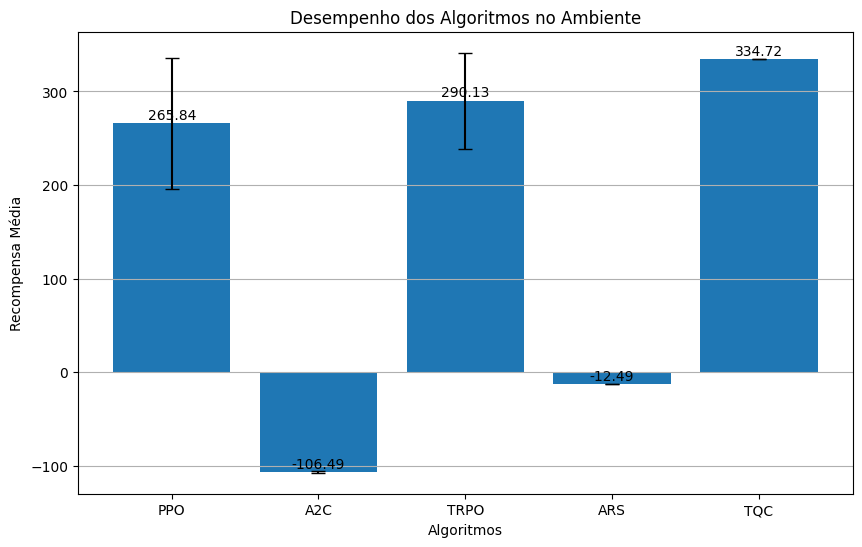

In [10]:
def test_performance(model_path, algo, env_id="BipedalWalker-v3", n_eval_episodes=10):
    
    env = make_vec_env(env_id, n_envs=1)
    
    model = algo.load(model_path, env=env)
   
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=False)
    return mean_reward, std_reward
import matplotlib.pyplot as plt

def draw_performance(results):
    algorithms, performances = zip(*results)
    means, stds = zip(*performances)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(algorithms, means, yerr=stds, capsize=5)  
    
    
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{mean:.2f}", ha="center", va="bottom")
    
    plt.xlabel("Algoritmos")
    plt.ylabel("Recompensa Média")
    plt.title("Desempenho dos Algoritmos no Ambiente")
    plt.grid(axis="y")
    plt.show()


model_paths = {
    "PPO": "models/PPO/5000000.zip",
    "A2C": "models/A2C/5000000.zip",
    "TRPO": "models/TRPO/5000000.zip",
    "ARS": "models/ARS/5000000.zip",
    "TQC": "models/TQC/3000000.zip",

}

algorithms = {
    "PPO": PPO,
    "A2C": A2C,
    "TRPO": TRPO,
    "ARS": ARS,
    "TQC": TQC
}


results = []
for algo_name, model_path in model_paths.items():
    try:
        print(f"Avaliando {algo_name}...")
        mean, std = test_performance(model_path, algorithms[algo_name])
        results.append((algo_name, (mean, std)))
    except Exception as e:
        print(f"Erro ao avaliar {algo_name}: {e}")

draw_performance(results)



We have chosen to focus exclusively on TQC, TRPO, and PPO models moving forward, as they are the only ones that demonstrate strong performance in the Base environment.

## Hardcore environment



In [ ]:
env_id = "BipedalWalkerHardcore-v3"


base_video_folder = "bipedalwalker-hard-videos"
training_period = 10_000
num_training_steps = 10_000_000
n_envs = 8
base_dir = "results"

os.makedirs(base_dir, exist_ok=True)

def make_env(env_id, rank, video_folder=None):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        if video_folder:
            env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 10 == 0)
        env = Monitor(env)
        return env
    return _init

models = {
    "PPO": PPO,
    "TQC": TQC,
    "TRPO": TRPO,
}

for model_name, model_class in models.items():
    print(f"Treinando modelo: {model_name}")
    model_video_folder = f"{base_video_folder}/{model_name}_videos"
    model_dir = f"{base_dir}/{model_name}_models"
    model_logs_dir = f"{base_dir}/{model_name}_logs"
    eval_logs_dir = f"{base_dir}/{model_name}_eval_logs"
    os.makedirs(model_video_folder, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_logs_dir, exist_ok=True)
    os.makedirs(eval_logs_dir, exist_ok=True)

    envs = SubprocVecEnv([make_env(env_id, i, model_video_folder if i == 0 else None) for i in range(n_envs)])
    envs = VecVideoRecorder(
        envs,
        video_folder=model_video_folder,
        record_video_trigger=lambda step: step % (training_period // n_envs) == 0,
        video_length=200
    )

    eval_env = gym.make(env_id)
    eval_env = Monitor(eval_env)

    model = model_class("MlpPolicy", envs, verbose=1, tensorboard_log=model_logs_dir)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=f"{model_dir}/best_model",
        log_path=eval_logs_dir,
        eval_freq=5000,
        deterministic=True,
    )
    checkpoint_callback = CheckpointCallback(
        save_freq=10000, save_path=model_dir, name_prefix=f"{model_name}_checkpoint"
    )

    model.set_logger(configure(model_logs_dir, ["stdout", "tensorboard"]))

    model.learn(
        total_timesteps=num_training_steps,
        callback=[eval_callback, checkpoint_callback]
    )

    model.save(f"{model_dir}/{model_name}_final_model")

    envs.close()
    eval_env.close()



### Results on Hard Environment

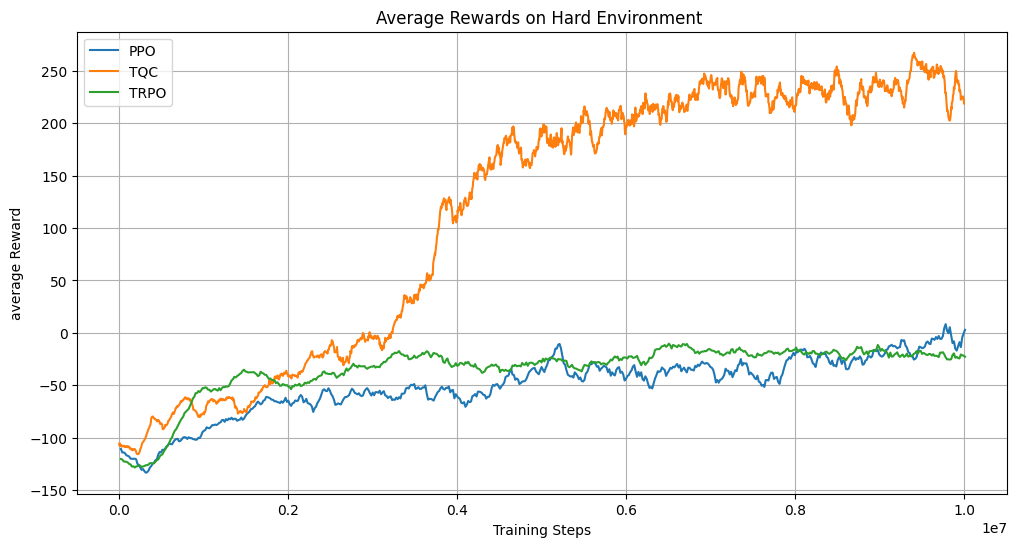

In [ ]:
base_dir = "results"
models = ["PPO", "TQC", "TRPO"]

def load_tensorboard_data(log_dir, metric="rollout/ep_rew_mean"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    if metric in ea.Tags()["scalars"]:
        scalar_data = ea.Scalars(metric)
        return pd.DataFrame(
            [(s.step, s.value) for s in scalar_data], columns=["Step", "Value"]
        )
    return None

data_frames = {}
for model in models:
    log_dir = os.path.join(base_dir, f"{model}_logs")
    df = load_tensorboard_data(log_dir)
    if df is not None:
        df["Model"] = model
        data_frames[model] = df

all_data = pd.concat(data_frames.values())

plt.figure(figsize=(12, 6))
for model in models:
    df = all_data[all_data["Model"] == model]
    plt.plot(df["Step"], df["Value"], label=model)

plt.title("Average Rewards on Hard Environment ")
plt.xlabel("Training Steps")
plt.ylabel("average Reward")
plt.legend()
plt.grid()
plt.show()


### Training on the Wrapped 1 Environment

To enhance the training process and ensure the agent can effectively learn within the **BipedalWalkerHardcore-v3** environment, we apply several wrappers:

- **NormalizeObservation**: Normalizes the environment's observations to have zero mean and unit variance, which stabilizes the training process.

- **FrameStackObservation**: Stacks the last 4 consecutive observations, providing temporal context and allowing the agent to infer the dynamics of the environment.

- **RecordEpisodeStatistics**: Tracks cumulative rewards, episode durations, and other performance metrics during training.

- **TimeLimit**: Restricts each episode to a maximum of 2000 steps, preventing the agent from getting stuck indefinitely.


In [ ]:
env_id = "BipedalWalkerHardcore-v3"
base_video_folder = "bipedalwalker-hard-videos-wrapped"
training_period = 10_000
num_training_steps = 10_000_000
n_envs = 8
base_dir = "results-wrapped"

def make_env(env_id, rank, video_folder=None):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        if video_folder:
            env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 10 == 0)
        env = NormalizeObservation(env)
        env = FrameStackObservation(env, stack_size=4)
        env = RecordEpisodeStatistics(env)
        env = TimeLimit(env, max_episode_steps=2000)
        env = Monitor(env)
        return env
    return _init

def make_eval_env(env_id):
    env = gym.make(env_id, render_mode="rgb_array")
    env = NormalizeObservation(env)
    env = FrameStackObservation(env, stack_size=4)
    env = TimeLimit(env, max_episode_steps=2000)
    env = Monitor(env)
    return env

models = {
    "PPO": PPO,
    "TQC": TQC,
    "TRPO": TRPO,
}

for model_name, model_class in models.items():
    print(f"Treinando modelo: {model_name}")
    
    model_video_folder = f"{base_video_folder}/{model_name}_videos"
    model_dir = f"{base_dir}/{model_name}_models"
    model_logs_dir = f"{base_dir}/{model_name}_logs"
    eval_logs_dir = f"{base_dir}/{model_name}_eval_logs"
    os.makedirs(model_video_folder, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_logs_dir, exist_ok=True)
    os.makedirs(eval_logs_dir, exist_ok=True)

    envs = SubprocVecEnv([make_env(env_id, i, model_video_folder if i == 0 else None) for i in range(n_envs)])
    envs = VecVideoRecorder(
        envs,
        video_folder=model_video_folder,
        record_video_trigger=lambda step: step % (training_period // n_envs) == 0,
        video_length=200
    )

    eval_env = make_eval_env(env_id)

    model = model_class("MlpPolicy", envs, verbose=1, tensorboard_log=model_logs_dir)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=f"{model_dir}/best_model",
        log_path=eval_logs_dir,
        eval_freq=5000,
        deterministic=True,
    )
    checkpoint_callback = CheckpointCallback(
        save_freq=10000, save_path=model_dir, name_prefix=f"{model_name}_checkpoint"
    )

    model.set_logger(configure(model_logs_dir, ["stdout", "tensorboard"]))

    model.learn(
        total_timesteps=num_training_steps,
        callback=[eval_callback, checkpoint_callback]
    )

    model.save(f"{model_dir}/{model_name}_final_model")

    envs.close()
    eval_env.close()




### Results on Wrapped 1 Environment

<module 'matplotlib.pyplot' from '/Users/franciscamihalache/opt/anaconda3/envs/GymEnv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

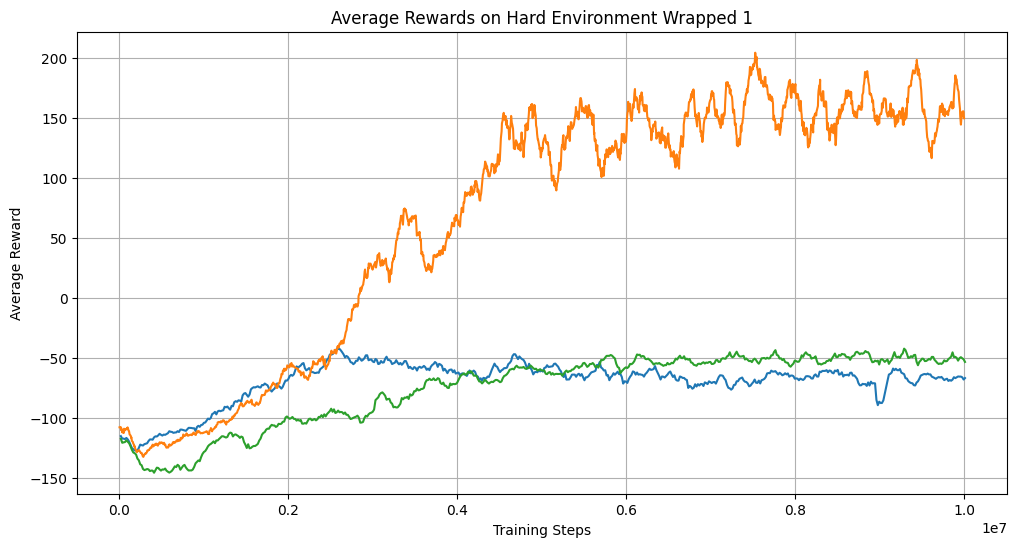

In [11]:
base_dir = "results-wrapped"
models = ["PPO", "TQC", "TRPO"]

def load_tensorboard_data(log_dir, metric="rollout/ep_rew_mean"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    if metric in ea.Tags()["scalars"]:
        scalar_data = ea.Scalars(metric)
        return pd.DataFrame(
            [(s.step, s.value) for s in scalar_data], columns=["Step", "Value"]
        )
    return None

data_frames = {}
for model in models:
    log_dir = os.path.join(base_dir, f"{model}_logs")
    df = load_tensorboard_data(log_dir)
    if df is not None:
        df["Model"] = model
        data_frames[model] = df

all_data = pd.concat(data_frames.values())

plt.figure(figsize=(12, 6))
for model in models:
    df = all_data[all_data["Model"] == model]
    plt.plot(df["Step"], df["Value"], label=model)

plt.title("Average Rewards on Hard Environment Wrapped 1")
plt.xlabel("Training Steps")
plt.ylabel("Average Reward")
plt.grid()
plt


### Training on the Wrapped 2 Environment

- **NormalizeReward**: Scales rewards to stabilize learning.

- **TransformReward**: Adjusts rewards by penalizing angles and rewarding progress.

- **Monitor**: Logs rewards and episode lengths detailed


In [ ]:
env_id = "BipedalWalkerHardcore-v3"
base_video_folder = "bipedalwalker-hard-videos-wrapped1"
training_period = 10_000
num_training_steps = 10_000_000
n_envs = 8
base_dir = "results-wrapped1"

def custom_reward(reward, info):
    angle_penalty = abs(info.get("angle", 0)) * 0.1
    progress_bonus = info.get("distance", 0) * 0.1
    return reward - angle_penalty + progress_bonus

def make_env(env_id, rank, video_folder=None):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        if video_folder:
            env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 10 == 0)
        env = NormalizeReward(env, gamma=0.99)
        env = gym.wrappers.TransformReward(env, lambda r: custom_reward(r, env.unwrapped.__dict__))
        env = Monitor(env)
        return env
    return _init

def make_eval_env(env_id):
    env = gym.make(env_id, render_mode="rgb_array")
    env = NormalizeReward(env, gamma=0.99)
    env = gym.wrappers.TransformReward(env, lambda r: custom_reward(r, env.unwrapped.__dict__))
    env = Monitor(env)
    return env

models = {
    "PPO": PPO,
    "TQC": TQC,
    "TRPO": TRPO,
}

for model_name, model_class in models.items():
    print(f"Treinando modelo: {model_name}")
    model_video_folder = f"{base_video_folder}/{model_name}_videos"
    model_dir = f"{base_dir}/{model_name}_models"
    model_logs_dir = f"{base_dir}/{model_name}_logs"
    eval_logs_dir = f"{base_dir}/{model_name}_eval_logs"
    os.makedirs(model_video_folder, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_logs_dir, exist_ok=True)
    os.makedirs(eval_logs_dir, exist_ok=True)

    envs = SubprocVecEnv([make_env(env_id, i, model_video_folder if i == 0 else None) for i in range(n_envs)])
    envs = VecVideoRecorder(
        envs,
        video_folder=model_video_folder,
        record_video_trigger=lambda step: step % (training_period // n_envs) == 0,
        video_length=200
    )

    eval_env = make_eval_env(env_id)

    model = model_class("MlpPolicy", envs, verbose=1, tensorboard_log=model_logs_dir)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=f"{model_dir}/best_model",
        log_path=eval_logs_dir,
        eval_freq=5000,
        deterministic=True,
    )
    checkpoint_callback = CheckpointCallback(
        save_freq=10000, save_path=model_dir, name_prefix=f"{model_name}_checkpoint"
    )

    model.set_logger(configure(model_logs_dir, ["stdout", "tensorboard"]))

    model.learn(
        total_timesteps=num_training_steps,
        callback=[eval_callback, checkpoint_callback]
    )

    model.save(f"{model_dir}/{model_name}_final_model")

    envs.close()
    eval_env.close()

print("Treinamento concluído para todos os modelos.")


### Results on Wrapped 2 Environment

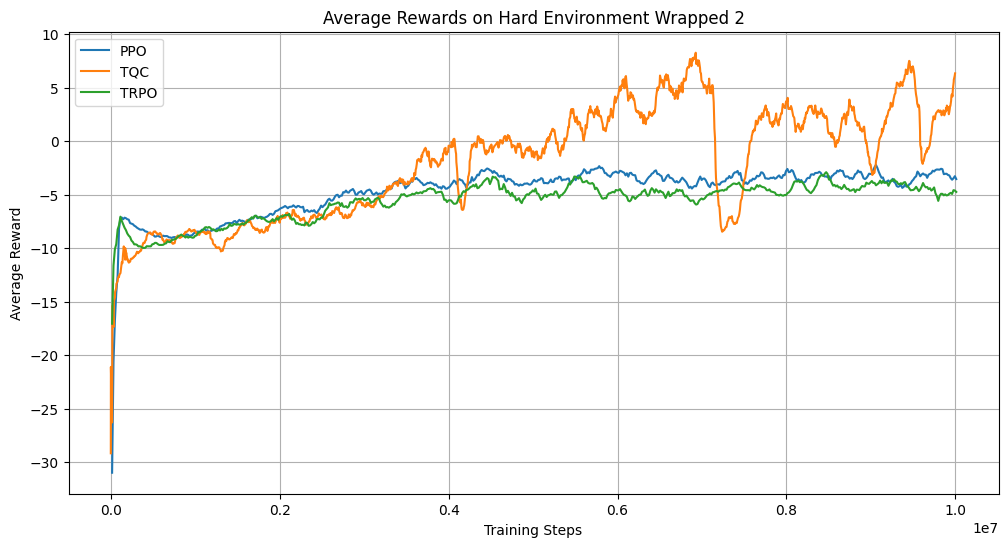

In [ ]:
base_dir = "results-wrapped1"
models = ["PPO", "TQC", "TRPO"]

def load_tensorboard_data(log_dir, metric="rollout/ep_rew_mean"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    if metric in ea.Tags()["scalars"]:
        scalar_data = ea.Scalars(metric)
        return pd.DataFrame(
            [(s.step, s.value) for s in scalar_data], columns=["Step", "Value"]
        )
    return None

data_frames = {}
for model in models:
    log_dir = os.path.join(base_dir, f"{model}_logs")
    df = load_tensorboard_data(log_dir)
    if df is not None:
        df["Model"] = model
        data_frames[model] = df

all_data = pd.concat(data_frames.values())

plt.figure(figsize=(12, 6))
for model in models:
    df = all_data[all_data["Model"] == model]
    plt.plot(df["Step"], df["Value"], label=model)

plt.title("Average Rewards on Hard Environment Wrapped 2")
plt.xlabel("Training Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()


### Training on the wrapped 3 environment

 The code applies multiple wrappers to customize the environment for the BipedalWalkerHardcore-v3 task. Below is a breakdown of the key changes introduced:
 
 **1. InfoCaptureWrapper**
- Captures the `info` dictionary returned by the environment at every step and stores it for the other wrappers.

**2. CustomRewardWrapper**
 - Customizes the reward function by introducing penalties:
  - **Angle Penalty**: Proportional to the absolute value of the `angle` information from `info`.
 - **Open Leg Penalty**: Proportional to the absolute value of `open_legs` (open legs) from `info`.
 - Encourages stable walking behavior by penalizing large deviations in angles or leg positions.

**3. RescaleAction**
- Rescales the action space to ensure finite bounds between [-1, 1].
 - Prevents the agent from issuing invalid actions.

**4. TimeAwareObservation**
 - Adds a normalized time component to the observations.
 - Helps the agent account for the time remaining in each episode.
 
**5. Monitor**
 - Monitors and logs statistics such as rewards, episode lengths, and custom metrics.
 - Ensures better tracking of the agent's performance during training and evaluation.


We trained it for 30M iterations

In [ ]:
env_id = "BipedalWalkerHardcore-v3"
base_video_folder = "bipedalwalker-hard-videos-wrapped2"
training_period = 10_000
num_training_steps = 30_000_000
n_envs = 8
base_dir = "results-wrapped2"

os.makedirs(base_dir, exist_ok=True)

class InfoCaptureWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.last_info = {}

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.last_info = info
        return obs, reward, terminated, truncated, info

class CustomRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def reward(self, reward):
        info = self.env.last_info
        angle_penalty = 0.1 * abs(info.get("angle", 0))
        open_leg_penalty = 0.05 * abs(info.get("pernas_abertas", 0))
        return reward - angle_penalty - open_leg_penalty

def make_env(env_id, rank, video_folder=None):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        if video_folder:
            env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 10 == 0)
        env = RescaleAction(env, min_action=-1.0, max_action=1.0)
        env = InfoCaptureWrapper(env)
        env = CustomRewardWrapper(env)
        env = TimeAwareObservation(env, normalize_time=True)
        env = Monitor(env)
        return env
    return _init

def make_eval_env(env_id):
    env = gym.make(env_id, render_mode="rgb_array")
    env = RescaleAction(env, min_action=-1.0, max_action=1.0)
    env = InfoCaptureWrapper(env)
    env = CustomRewardWrapper(env)
    env = TimeAwareObservation(env, normalize_time=True)
    env = Monitor(env)
    return env

models = {
    "TQC": TQC,
}

for model_name, model_class in models.items():
    print(f"Treinando modelo: {model_name}")
    model_video_folder = f"{base_video_folder}/{model_name}_videos"
    model_dir = f"{base_dir}/{model_name}_models"
    model_logs_dir = f"{base_dir}/{model_name}_logs"
    eval_logs_dir = f"{base_dir}/{model_name}_eval_logs"
    os.makedirs(model_video_folder, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_logs_dir, exist_ok=True)
    os.makedirs(eval_logs_dir, exist_ok=True)

    envs = DummyVecEnv([make_env(env_id, i, model_video_folder if i == 0 else None) for i in range(n_envs)])
    envs = VecVideoRecorder(
        envs,
        video_folder=model_video_folder,
        record_video_trigger=lambda step: step % (training_period // n_envs) == 0,
        video_length=200
    )

    eval_env = make_eval_env(env_id)

    model = model_class("MlpPolicy", envs, verbose=1, tensorboard_log=model_logs_dir)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=f"{model_dir}/best_model",
        log_path=eval_logs_dir,
        eval_freq=5000,
        deterministic=True,
    )
    checkpoint_callback = CheckpointCallback(
        save_freq=10000, save_path=model_dir, name_prefix=f"{model_name}_checkpoint"
    )

    model.set_logger(configure(model_logs_dir, ["stdout", "tensorboard"]))

    model.learn(
        total_timesteps=num_training_steps,
        callback=[eval_callback, checkpoint_callback]
    )

    model.save(f"{model_dir}/{model_name}_final_model")

    envs.close()
    eval_env.close()



### Results on Wrapped 3 Environment

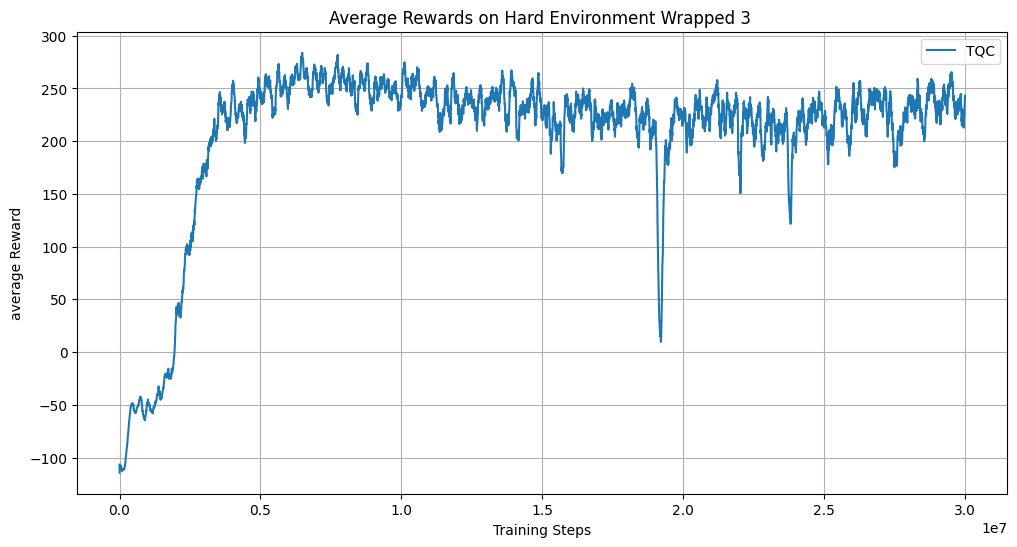

In [5]:
base_dir = "results-wrapped2"
models = ["TQC"]

def load_tensorboard_data(log_dir, metric="rollout/ep_rew_mean"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    if metric in ea.Tags()["scalars"]:
        scalar_data = ea.Scalars(metric)
        return pd.DataFrame(
            [(s.step, s.value) for s in scalar_data], columns=["Step", "Value"]
        )
    return None

data_frames = {}
for model in models:
    log_dir = os.path.join(base_dir, f"{model}_logs")
    df = load_tensorboard_data(log_dir)
    if df is not None:
        df["Model"] = model
        data_frames[model] = df

all_data = pd.concat(data_frames.values())

plt.figure(figsize=(12, 6))
for model in models:
    df = all_data[all_data["Model"] == model]
    plt.plot(df["Step"], df["Value"], label=model)

plt.title("Average Rewards on Hard Environment Wrapped 3 ")
plt.xlabel("Training Steps")
plt.ylabel("average Reward")
plt.legend()
plt.grid()
plt.show()


### Comparison between TQC original and TQC Wrapped 3

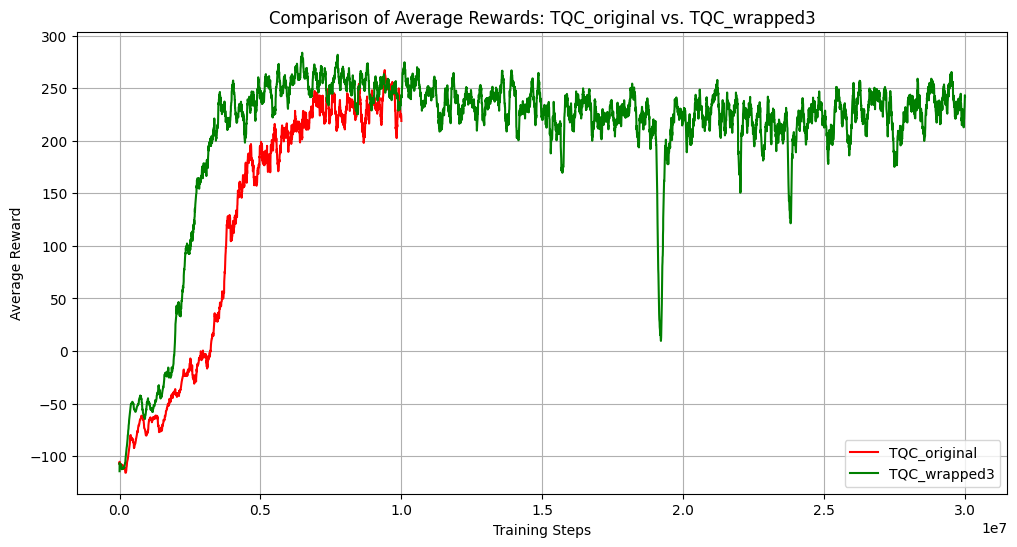

In [4]:
def load_tensorboard_data(log_dir, metric="rollout/ep_rew_mean"):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    if metric in ea.Tags()["scalars"]:
        scalar_data = ea.Scalars(metric)
        return pd.DataFrame(
            [(s.step, s.value) for s in scalar_data], columns=["Step", "Value"]
        )
    return None


base_dirs = {
    "TQC_original": "results/TQC_logs",
    "TQC_wrapped3": "results-wrapped2/TQC_logs"
}

data_frames = {}
for model, log_dir in base_dirs.items():
    df = load_tensorboard_data(log_dir)
    if df is not None:
        df["Model"] = model
        data_frames[model] = df

all_data = pd.concat(data_frames.values())

plt.figure(figsize=(12, 6))
colors = {"TQC_original": "red", "TQC_wrapped3": "green"}

for model, color in colors.items():
    df = all_data[all_data["Model"] == model]
    plt.plot(df["Step"], df["Value"], label=model, color=color)

plt.title("Comparison of Average Rewards: TQC_original vs. TQC_wrapped3")
plt.xlabel("Training Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()


## Why TQC Outperformed PPO and TRPO ?


| Feature                                  | **TQC**                                                                                   | **PPO** / **TRPO**                                                                       |
|------------------------------------------|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **Learning Type**                        | Off-policy: Utilizes stored data from a replay buffer for sample-efficient learning.      | On-policy: Only learns from data collected by the current policy, less efficient.       |
| **Designed For**                         | Complex continuous control environments.                                                 | Originally designed for discrete environments, adapted for continuous control.          |
| **Handling Outliers**                    | Reduces impact of extreme values by ignoring higher quantiles (positive outliers).       | No specific mechanism for handling outliers, making learning less stable.               |
| **Sample Efficiency**                    | Requires fewer samples to learn effective policies.                                       | Requires constant new sampling, increasing computational costs.                         |
| **Exploration vs Exploitation**          | Balances exploration and exploitation effectively via truncated quantile learning.        | Prone to getting stuck in local minima due to gradient-based optimization.              |
| **Adaptability to Custom Rewards**       | More capable of benefiting from custom reward systems due to its flexible Q-value critics.| Less flexible in leveraging custom reward structures.                                   |


### Future work: 
Enhance the complexity of the environment by adding flying objects or dynamic obstacles.

Conduct experiments with extended training iterations

Perform an in-depth optimization of hyperparameters for TQC, PPO, and TRPO.
